In [1]:
from mlrl.runners.dqn_runner import DQNRun
from mlrl.experiments.procgen_dqn import make_procgen, create_rainbow_agent

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
folder = './sync/dqn/categorical_dqn_agent/run-16823527592836354'

import json

with open(folder + '/config.json') as f:
    config = json.load(f)

config

{'action_repeats': 4,
 'agent_name': 'categorical_dqn_agent',
 'collect_steps_per_iteration': 1,
 'discount': 0.999,
 'env': 'bigfish',
 'epsilon': 0.1,
 'epsilon_decay_steps': 250000,
 'epsilon_schedule': False,
 'eval_steps': 1000,
 'experience_batch_size': 64,
 'final_epsilon': 0.1,
 'frame_stack': 0,
 'grayscale': False,
 'initial_collect_steps': 500,
 'initial_epsilon': 1.0,
 'learning_rate': 0.00025,
 'max_epochs': 500,
 'metrics': [],
 'model_config': 'N/A',
 'n_collect_envs': 64,
 'n_eval_envs': 64,
 'n_video_envs': 12,
 'name': 'run',
 'optimiser_config': {'amsgrad': False,
  'beta_1': 0.8999999761581421,
  'beta_2': 0.9990000128746033,
  'decay': 0.0,
  'epsilon': 1e-07,
  'learning_rate': 0.0002500000118743628,
  'name': 'Adam'},
 'procgen_env_name': 'bigfish',
 'replay_buffer_capacity': 1024,
 'run_dir': './runs/categorical_dqn_agent/run-16823527592836354',
 'target_network_update_period': 10000,
 'train_steps_per_epoch': 20000,
 'video_seconds': 60}

In [3]:
env_name = config.get('env')
env = make_procgen(env_name, config, n_envs=1)
q_net, agent = create_rainbow_agent(env, config)

Building Categorical Q-Network weights...


In [4]:
q_vals, _ = q_net(env.current_time_step().observation)
q_vals.shape

TensorShape([1, 15, 51])

In [5]:
import re
from typing import Tuple


def parse_model_weights_string(path: str) -> Tuple[int, float]:
    pattern = r"sequential_best_(\d+)_(\d+\.\d+).index"

    match = re.match(pattern, path)

    if match:
        epoch = int(match.group(1))
        value = float(match.group(2))
        return epoch, value

    return None

In [6]:
from pathlib import Path

model_paths = [
    (str(path).replace('.index', ''), *values)
    for path in Path(f'{folder}/model_weights').glob('*')
    if path.is_file() and str(path).endswith('.index') 
        and (values := parse_model_weights_string(str(path.name))) is not None
]

In [7]:
path, epoch, ret_val = max(model_paths, key=lambda x: x[2])
path, epoch, ret_val

('sync/dqn/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_65_40.599998',
 65,
 40.599998)

In [8]:
chkpt_status = q_net.load_weights(path)

In [9]:
q_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CategoricalQNetwork (Catego  ((1, 15, 51),            638909    
 ricalQNetwork)               ())                                
                                                                 
Total params: 638,909
Trainable params: 638,909
Non-trainable params: 0
_________________________________________________________________


In [40]:
from mlrl.runners.eval_runner import EvalRunner

In [41]:
eval_runner = EvalRunner(10000 * env.batch_size, env, agent.policy)

In [42]:
eval_runner.run()

10000/10000 [==============================] - 35s 3ms/step - AverageReturn: 58.4475
Evaluation stats:
EvalNumberOfEpisodes: 30.000, EvalEnvironmentSteps: 10000.000, EvalAverageReturn: 52.000, EvalAverageEpisodeLength: 329.567, EvalTime: 34.671


{'EvalNumberOfEpisodes': 30,
 'EvalEnvironmentSteps': 10000,
 'EvalAverageReturn': 52.0,
 'EvalAverageEpisodeLength': 329.56668,
 'EvalTime': 34.67051649093628}

In [43]:
from mlrl.experiments.procgen_dqn import create_video_renderer
from mlrl.utils.render_utils import embed_mp4

In [44]:
renderer = create_video_renderer(env_name, config)

In [45]:
embed_mp4(renderer(agent.policy, 'video.mp4'))

In [10]:
from mlrl.meta.search_tree import ObjectState
from mlrl.utils import one_hot

from typing import List

import tensorflow as tf
import numpy as np

from gym3.env import Env
from procgen.env import ProcgenGym3Env


class ProcgenProcessing:
    __instance = None

    def __init__(self, agent):
        self.categorical_q_net = agent._q_network
        self.support = agent._support

    @staticmethod
    def set_network(agent):
        ProcgenProcessing.__instance = ProcgenProcessing(agent)

    @staticmethod
    def call(observation) -> np.ndarray:
        categorical_q_net = ProcgenProcessing.__instance.categorical_q_net
        n_actions = categorical_q_net._num_actions
        n_atoms = categorical_q_net._num_atoms

        encs, _ = categorical_q_net._q_network._encoder(observation)
        
        q_logits = categorical_q_net._q_network._q_value_layer(encs)
        q_logits = tf.reshape(q_logits, [-1, n_actions, n_atoms])
        q_probabilities = tf.nn.softmax(q_logits)
        q_values = tf.reduce_sum(agent._support * q_probabilities, axis=-1)

        return encs.numpy().squeeze(), q_values.numpy().squeeze()


class ProcgenState(ObjectState):
    """
    Class to represent a state of a procgen environment.
    """
    __slots__ = ['state_vec', 'state', 'observation', 'q_values']

    COMBO_STRINGS = [
        '+'.join(combo)
        for combo in ProcgenGym3Env.get_combos(None)
    ]

    ACTIONS = list(range(len(COMBO_STRINGS)))

    @staticmethod
    def extract_state(env: Env) -> 'ProcgenState':
        """
        A static method to extract the state of the environment
        for later restoring and representation.
        """
        return ProcgenState(env)

    def __init__(self, env: Env):
        self.env_state = env.callmethod('get_state')
        self.observation = env.current_time_step().observation
        self.state_vec, self.q_values = ProcgenProcessing.call(self.observation)

    def set_environment_to_state(self, env: Env):
        env.callmethod('set_state', self.env_state)

    def get_state_vector(self) -> np.array:
        return np.array(self.state_vec, dtype=np.float32)

    def get_maximum_number_of_actions(self):
        return len(ProcgenState.COMBO_STRINGS)

    def get_actions(self) -> List[int]:
        return ProcgenState.ACTIONS

    def get_action_labels(self) -> List[str]:
        return ProcgenState.COMBO_STRINGS

    def get_action_vector(self, action: int) -> np.array:
        n = self.get_maximum_number_of_actions()
        return one_hot(action, n)

    def get_state_string(self) -> str:
        return ''

    def __repr__(self) -> str:
        return f'{type(self).__name__}({self.get_state_string()})'

In [11]:
ProcgenProcessing.set_network(agent)

In [19]:
state = ProcgenState.extract_state(env)
state

ProcgenState()

In [30]:
hash(str(state.state_vec))

-536093818742124342

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

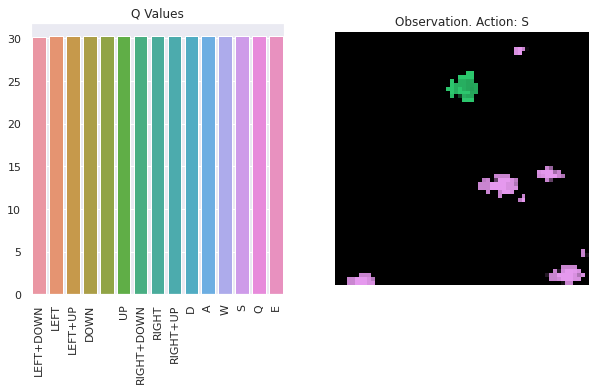

In [50]:
from IPython.display import clear_output

try:
    for _ in range(1000):
        ts = env.current_time_step()
        action = agent.policy.action(ts).action
        env.step(action)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        state = ProcgenState.extract_state(env)
        obs = state.observation
        q_values = state.q_values

        sns.barplot(x=np.arange(len(q_values)), y=q_values, ax=axs[0])
        axs[0].set_xticklabels(ProcgenState.COMBO_STRINGS, rotation=90)
        axs[0].set_title('Q Values')

        axs[1].imshow(obs[0])
        axs[1].set_title(f'Observation. Action: {ProcgenState.COMBO_STRINGS[action.numpy()[0]]}')
        axs[1].axis('off')

        plt.show()

        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [38]:
env.step(0).reward

array([0.], dtype=float32)

In [16]:
from mlrl.experiments.experiment_utils import create_meta_env

object_env = env
q_hat = lambda s, a: s.q_values[a]

meta_config = dict()

meta_env = create_meta_env(
    object_env, ProcgenState.extract_state(object_env),
    q_hat, meta_config,
    # tree_policy_renderer=render_tree_policy,
    # min_computation_steps=min_computation_steps
)

ValueError: The number of FixedLocator locations (95), usually from a call to set_ticks, does not match the number of ticklabels (566).

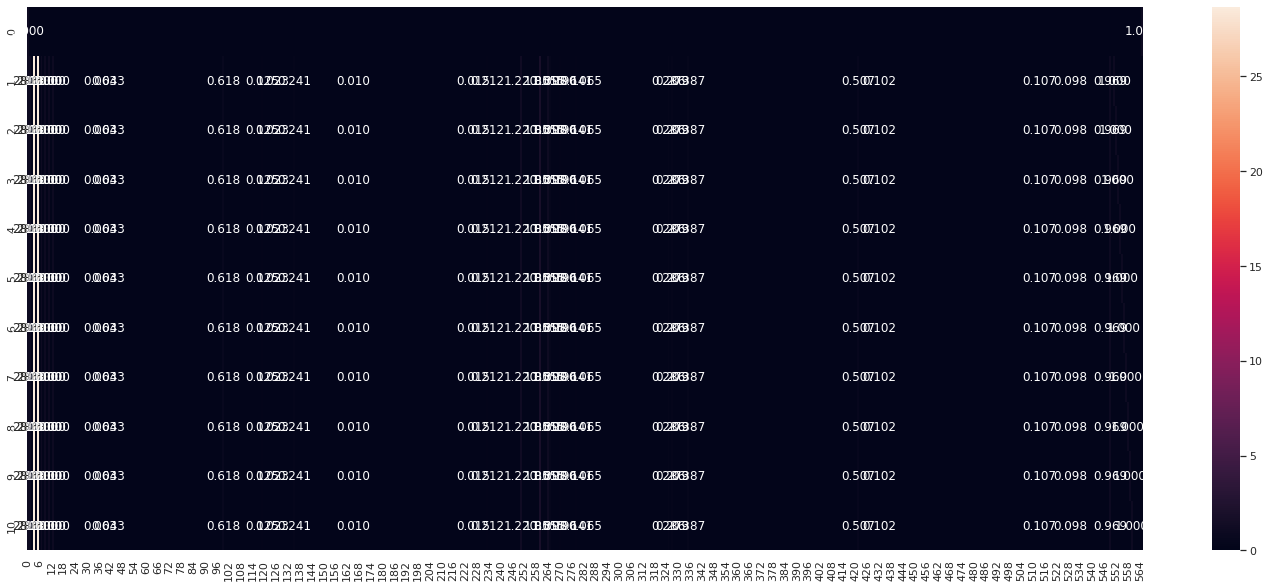

In [39]:
meta_env.step(0)

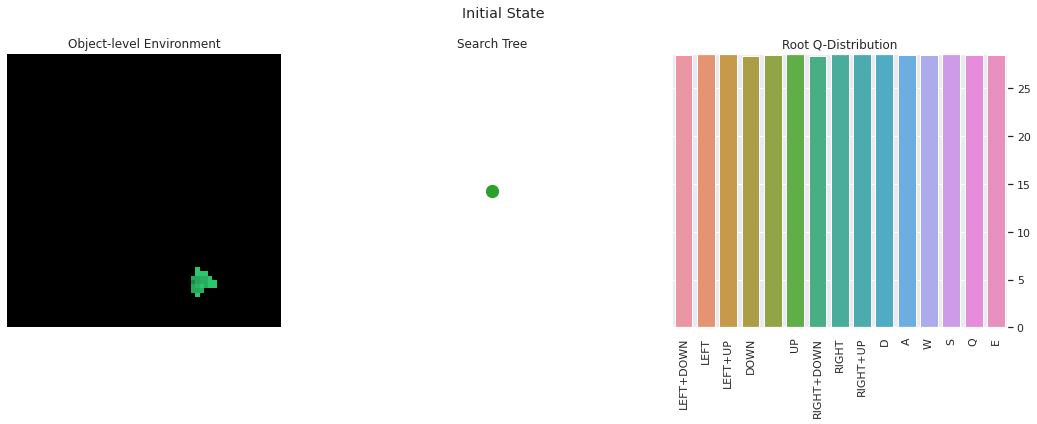

In [18]:
meta_env.render(plt_show=True);